<a href="https://colab.research.google.com/github/ZzzTheGamer/XAI/blob/Assignment9_Human-AI-Interaction/CreditRisk_Shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Credit Risk Prediction with SHAP Interpretability
* External source from https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/local_explanations.ipynb
* GPT 4o used for polishing the language used.

### 1. Data Source
The dataset utilized in this analysis originates from Kaggle's publicly available dataset titled Credit Risk Dataset (https://www.kaggle.com/datasets/laotse/credit-risk-dataset/data). This dataset contains detailed financial and demographic information to assess and predict the credit risk of individual borrowers.

### 2. Data Description

| Feature Name                | Description                             |
|-----------------------------|-----------------------------------------|
| person_age               | Age of the borrower                     |
| person_income             | Annual income of the borrower           |
| person_home_ownership     | Home ownership status                   |
| person_emp_length         | Employment length in years              |
| loan_intent               | Purpose of the loan                     |
| loan_grade                | Risk grade of the loan                  |
| loan_amnt                 | Loan amount requested                   |
| loan_int_rate             | Loan interest rate                      |
| loan_status               | Loan status (0 = non-default, 1 = default) |
| loan_percent_income       | Loan amount as percentage of income     |
| cb_person_default_on_file | Historical default status               |
| cb_preson_cred_hist_length| Length of credit history                |


### 3. Importing libraries and data

In [1]:
# Import necessary libraries for data processing, modeling, and interpretation
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import shap

In [2]:
# Load the dataset
data = pd.read_csv('credit_risk_dataset.csv')
data = data.dropna()

### 4. Perform label encoding for categorical variables

In [3]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Create a dictionary to store mappings of original categorical labels
encoding_map = {}

# Encode categorical columns
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = label_encoder.fit_transform(data[col].astype(str))
        encoding_map[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the encoding map
print("Encoding Map:")
for col, mapping in encoding_map.items():
    print(col, ":", mapping)

Encoding Map:
person_home_ownership : {'MORTGAGE': 0, 'OTHER': 1, 'OWN': 2, 'RENT': 3}
loan_intent : {'DEBTCONSOLIDATION': 0, 'EDUCATION': 1, 'HOMEIMPROVEMENT': 2, 'MEDICAL': 3, 'PERSONAL': 4, 'VENTURE': 5}
loan_grade : {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
cb_person_default_on_file : {'N': 0, 'Y': 1}


### 5. Splitting dataset

In [4]:
# Split the data into features and target variable
X = data.drop('loan_status', axis=1)
y = data['loan_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 6. Model training and performance comparison

In [5]:
# Define models to evaluate their performance
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

In [6]:
# Define parameter grids for hyperparameter tuning for each model
param_grid = {
    'Decision Tree': {'max_depth': [3, 5, 7, None]},
    'Random Forest': {'n_estimators': [50, 100], 'max_depth': [3, 5, 7]},
    'XGBoost': {'n_estimators': [50, 100], 'max_depth': [3, 5, 7]}
}

In [7]:
# Initialize variables to store the best model and its accuracy
best_model, best_score, best_name = None, 0, ''

# Perform grid search to find optimal hyperparameters and the corresponding model
for name, model in models.items():
    grid = GridSearchCV(model, param_grid[name], cv=3, scoring='accuracy')
    grid.fit(X_train, y_train)
    print(f"{name} best params: {grid.best_params_}")
    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc}\n")
    # Update best model if current model performs better
    if acc > best_score:
        best_score, best_model, best_name = acc, grid.best_estimator_, name

Decision Tree best params: {'max_depth': 7}
Decision Tree Accuracy: 0.9200418994413407

Random Forest best params: {'max_depth': 7, 'n_estimators': 100}
Random Forest Accuracy: 0.91393156424581

XGBoost best params: {'max_depth': 5, 'n_estimators': 100}
XGBoost Accuracy: 0.9364525139664804



In [8]:
# Display the best model and its accuracy
print(f"Best Model: {best_name} with accuracy {best_score}")

Best Model: XGBoost with accuracy 0.9364525139664804


In [9]:
# Train the best model on the training data
best_model = XGBClassifier(max_depth=5, n_estimators=100, random_state=42, eval_metric='logloss')
best_model.fit(X_train, y_train)

# Make predictions with the best model on the test set
y_pred = best_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9364525139664804

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4443
           1       0.98      0.73      0.84      1285

    accuracy                           0.94      5728
   macro avg       0.95      0.86      0.90      5728
weighted avg       0.94      0.94      0.93      5728


Confusion Matrix:
[[4421   22]
 [ 342  943]]


### 7. Rationale for selecting SHAP

SHAP (Shapley Additive Explanations) is an explainability method derived from game theory. It decomposes the prediction of a complex model into additive feature contributions called **Shapley values**. These values represent how each individual feature contributes to the prediction relative to a baseline.

**Why we choose SHAP?**

- **Global Interpretability**:  
  SHAP provides an overview of feature importance across the entire dataset. For instance, it helps identify whether features such as income or loan interest rate generally contribute positively or negatively towards loan default prediction.

- **Local Interpretability**:  
  SHAP enables explanation at the individual prediction level, clearly indicating why a particular borrower is classified as high or low risk.

- **Consistency**:  
  Unlike some interpretability methods, SHAP follows consistency principles, ensuring that as a feature's predictive strength increases, its Shapley value magnitude increases proportionally.

- **Flexibility**:  
  SHAP is flexible and applicable across various model types, including decision trees, neural networks, and linear models, etc.


### 8. Model Interpretation using SHAP

In [10]:
# Use SHAP to explain the predictions made by the best model
explainer = shap.Explainer(best_model.predict, X_test)
shap_values = explainer(X_test)

PermutationExplainer explainer: 5729it [10:57,  8.61it/s]


### 9. Visualize SHAP values to interpret the model's predictions

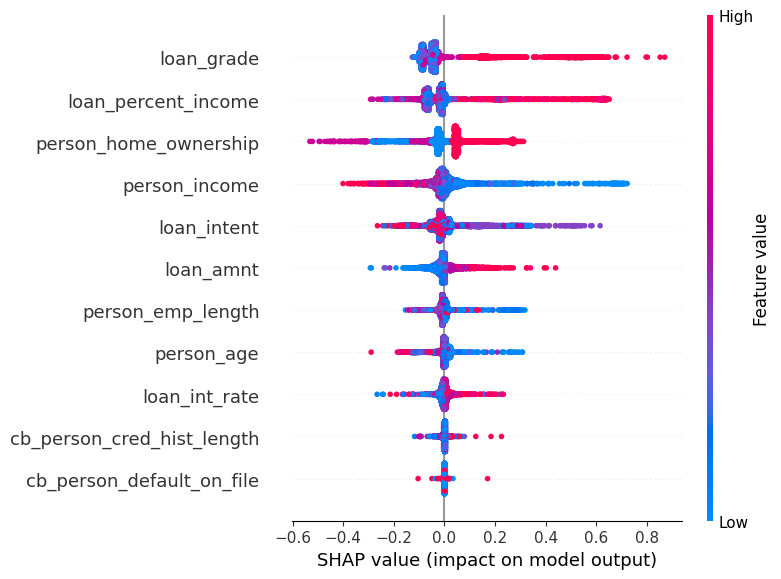

In [11]:
# Summary plot
shap.summary_plot(shap_values, X_test)

* y-axis interpretation:
Features are listed vertically according to their overall importance in predicting loan defaults. The most important features appear at the top (e.g., loan_grade, loan_percent_income).
* x-axis interpretation:
Positive SHAP values (right side) indicates a higher probability of loan default. Negative SHAP values indicates that the feature value reduces the probability of default.
* color interpretation:
Red indicates high values for that feature. Blue indicates low values for that feature.
- From this graph, we can see for loan_grade, high values (lower-quality loan grades) significantly increase default risk (positive SHAP values to the right).
- For loan_percent_income, high loan percentages relative to income (red) significantly increase default risk.
- For person_income, higher incomes (red points) reduce default risk (negative SHAP values to the left side).

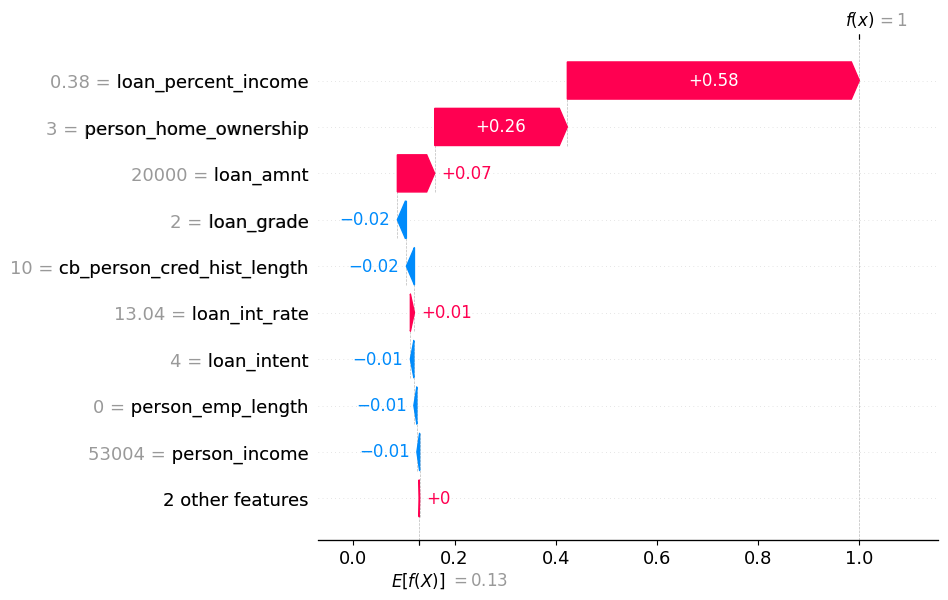

In [13]:
# Waterfall plot
shap.waterfall_plot(shap_values[1])

* Base value (E[f(x)]): This is the average prediction across all instances in the dataset without additional information (0.13 in this case). It serves as a reference point for interpretation.
* SHAP values here represents by arrows showing how each feature pushes the prediction away from the base value.
* From this graph, we can see for a borrower, with a contribution of +0.58, loan percent income significantly increases the default probability.
* Person home ownership contributes +0.26 to risk, suggesting that this borrower's specific home ownership status (3) significantly increases their default probability.
* Loan amount contributes positively (+0.07) but less significantly compared to loan_percent_income.
* Factors such as lower loan_grade and others slightly lower the risk (negative values shown in blue, e.g., -0.02) but their contribution is minor


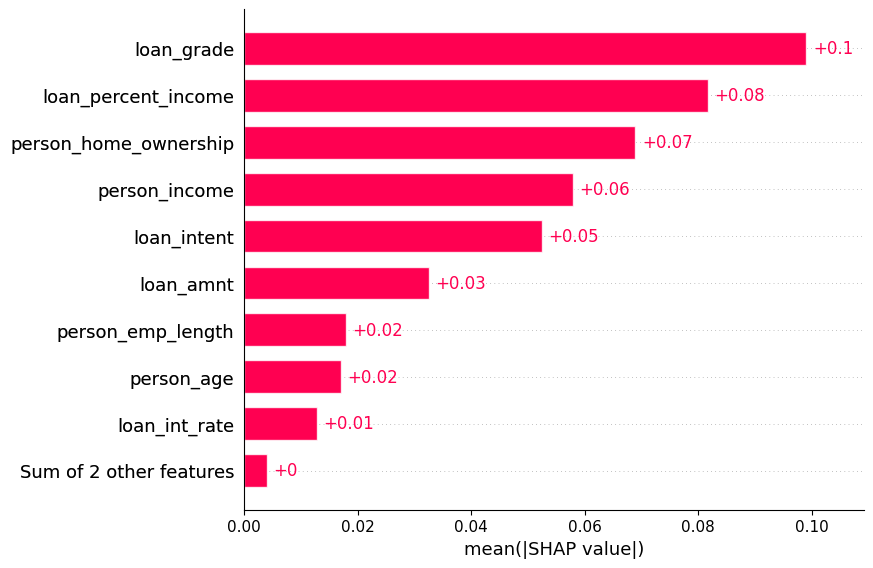

In [14]:
# Feature importance
shap.plots.bar(shap_values)

* This graph shows the average absolute contribution (mean SHAP value) of each feature to the model's predictions across the entire dataset.
* Here we seletc some top influential features to interpret:
* We can see loan_grade (0.10) is most influential feature, indicating that loan grades strongly affect default predictions. Lower quality loan (E,F,G,etc) significantly increase default likelihood.
* For loan_percent_income (0.08), we can see loans that represent a high percentage of a borrower's income greatly impact default predictions. Higher loan-to-income ratios generally increase the risk of default.
* Person_home_ownership (0.07) also strongly influences risk predictions, indicating different ownership types (such as renting versus owning) have different associated risks.